These files should be in your working directory: "train_2024.csv", "test_2024.csv", "answer_key_2024.csv"

In [2]:
import os
os.getcwd()
#os.chdir()

'C:\\Users\\veldh\\OneDrive\\Documenten\\Epidemiology\\Basics of ML\\BMLB2024\\BMBIO-Project-Rick-en-Sam'

In [3]:
# load packages
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import sklearn
import math
from IPython.display import display, Markdown
from sklearn.utils import resample
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score

In [4]:
# load data
df = pd.read_csv("train_2024.csv")
df.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000,Outcome,Id
0,4.0,107.0,135.0,15752.0,459.0,189.0,222.0,2258.0,2992.0,77.0,...,156.0,18368.0,318.0,89.0,307.0,82.0,227.0,302.0,3,3328
1,4.0,96.0,130.0,13704.0,486.0,244.0,298.0,NaN,1874.0,50.0,...,82.0,21033.0,375.0,NaN,426.0,91.0,232.0,116.0,1,2085
2,5.0,139.0,71.0,13866.0,326.0,418.0,402.0,2833.0,1821.0,64.0,...,122.0,13853.0,244.0,114.0,273.0,87.0,219.0,NaN,3,2455
3,3.0,135.0,47.0,14945.0,432.0,239.0,224.0,3020.0,2958.0,69.0,...,50.0,16328.0,289.0,NaN,NaN,98.0,244.0,312.0,3,2457
4,2.0,69.0,48.0,8758.0,337.0,214.0,358.0,NaN,3388.0,80.0,...,119.0,10714.0,557.0,99.0,206.0,107.0,136.0,364.0,1,3641


In [5]:
# 1: How many missing data are there?
# There is quite some data missing per feature.

missing_values = df.isnull().sum()
missing_percentage = missing_values/len(df)

print(missing_values,"\n")
print(missing_percentage)

Gene 1       250
Gene 2       237
Gene 3       266
Gene 4       255
Gene 5       249
            ... 
Gene 1998    259
Gene 1999    252
Gene 2000    236
Outcome        0
Id             0
Length: 2002, dtype: int64 

Gene 1       0.071023
Gene 2       0.067330
Gene 3       0.075568
Gene 4       0.072443
Gene 5       0.070739
               ...   
Gene 1998    0.073580
Gene 1999    0.071591
Gene 2000    0.067045
Outcome      0.000000
Id           0.000000
Length: 2002, dtype: float64


In [6]:
# 2: Are there other strange values in the data?
# There are no values lower than 0, this is what you would expect, as negative gene expression is not possible.

strange_values = (df < 0).sum()
print(strange_values)
print("There are",str(sum(strange_values)), "strange values.")

Gene 1       0
Gene 2       0
Gene 3       0
Gene 4       0
Gene 5       0
            ..
Gene 1998    0
Gene 1999    0
Gene 2000    0
Outcome      0
Id           0
Length: 2002, dtype: int64
There are 0 strange values.


In [7]:
# 3: What is the proportion of classes in your data?
# It seems that class 3.0 has the highest proportion out of the 4 classes.

class_proportions = df['Outcome'].value_counts(normalize=True)
class_proportions

Outcome
3    0.363636
2    0.250284
1    0.207386
0    0.178693
Name: proportion, dtype: float64

Axes(0.125,0.11;0.62x0.77)


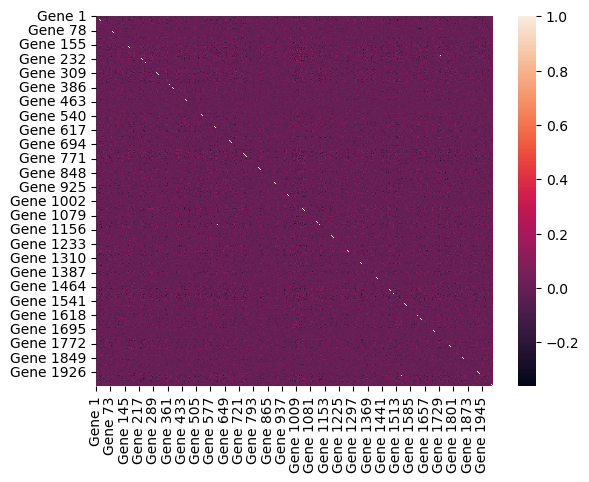

In [8]:
# 4: Are there genes (features) that are extremely highly correlated with each other? if so, how many?
# Based on the criteria that a correlation > 0.9 is extremely high, we found 1024 highly correlating gene pairs.

correlation_matrix = df.drop(['Outcome', 'Id'], axis=1).corr()
feature_data=pd.DataFrame(correlation_matrix)
correlation_heatmap=sns.heatmap(feature_data)
print(correlation_heatmap)
#print(correlation_matrix)

In [9]:
highly_correlated_pairs = np.where(np.abs(correlation_matrix) > 0.9)
print(highly_correlated_pairs)

(array([   0,    1,    2, ..., 1997, 1998, 1999], dtype=int64), array([   0,    1,    2, ..., 1997, 1998, 1999], dtype=int64))


In [10]:
high_correlation_count = len(highly_correlated_pairs[0]) // 2
print(high_correlation_count)

1059


In [11]:
# 5: What is the maximum value in the data, and the minimum?
# We see that the maximum value in the data is 50079.0 and the minimum value is 0.

feature_data.head()
max_value = df.max().max()
min_value = df.min().min()

print("The mamixum value in the data is from",str(max(feature_data)),"and is",str(max_value))
print("The minimum value in the data is",str(min_value))


The mamixum value in the data is from Gene 999 and is 51663.0
The minimum value in the data is 0.0


In [12]:
#6: Which feature has the highest variance?
# We see that Gene 1127 has the highest variance: 45748470.03168018

feature_variances = df.var()
highest_variance_feature = feature_variances.idxmax()

print(f'Highest feature variance: {feature_variances.max()}')
print(f'Feature with the highest variance: {highest_variance_feature}')

#Confirm findings
print('\n',feature_variances['Gene 1127'])

Highest feature variance: 44663714.32831292
Feature with the highest variance: Gene 1127

 44663714.32831292


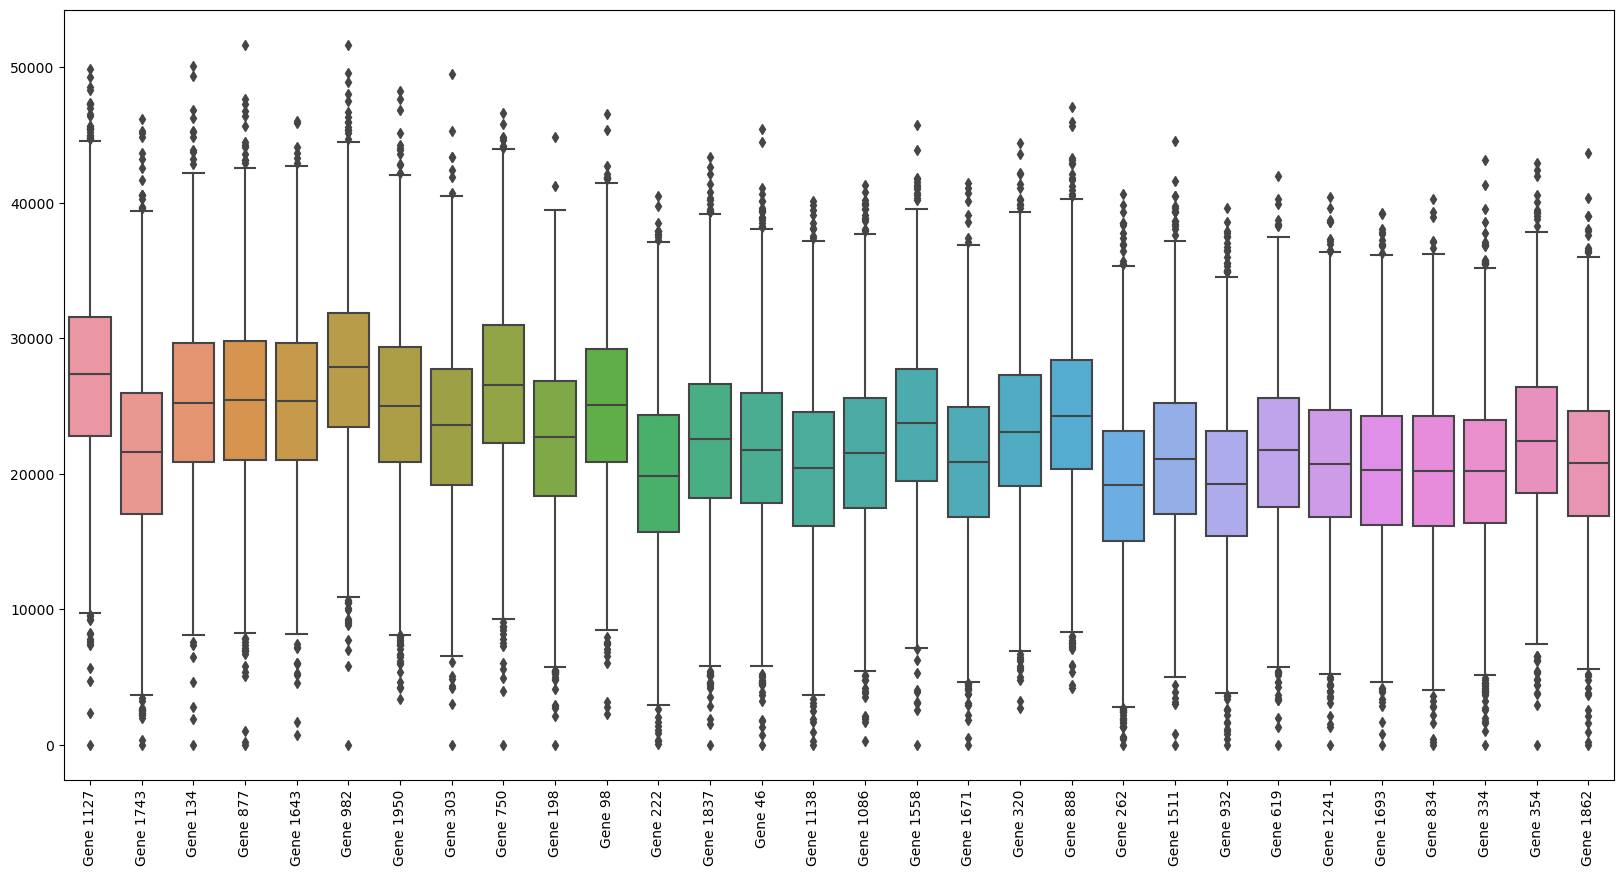

In [13]:
#7:
# In this boxplot we show the expression values of the 30 features with the highest variance in the dataset.

top_30_variances = feature_variances.nlargest(30)
top_30_features = df[top_30_variances.index]

# Plotting boxplot
plt.figure(figsize=(20,10))
sns.boxplot(data=top_30_features)
plt.xticks(rotation=90)
plt.show()

In [14]:
min_class_size = df['Outcome'].value_counts().min()

# Function to downsample
def downsample(group):
  return group.sample(n=min_class_size, random_state=123)

# Apply on original dataframe
downsampled_df = df.groupby('Outcome').apply(downsample).reset_index(drop=True)

In [15]:
print(downsampled_df.head(),"\n")
print(downsampled_df.tail(),"\n")

# Check if it correctly resampled
print(downsampled_df['Outcome'].value_counts())

   Gene 1  Gene 2  Gene 3   Gene 4  Gene 5  Gene 6  Gene 7  Gene 8  Gene 9  \
0     4.0   120.0    63.0  10279.0     NaN   262.0   482.0  3512.0  3313.0   
1     NaN    83.0    80.0  15986.0   399.0   212.0   191.0  2813.0  2303.0   
2     2.0   107.0   137.0  13191.0   452.0   319.0   309.0  3026.0  2846.0   
3     4.0    78.0   126.0  13570.0   222.0   186.0   186.0  1647.0  2601.0   
4     4.0   131.0    81.0  10289.0   390.0   218.0   279.0  2530.0  2006.0   

   Gene 10  ...  Gene 1993  Gene 1994  Gene 1995  Gene 1996  Gene 1997  \
0     38.0  ...      174.0    15206.0      296.0      111.0      385.0   
1     60.0  ...      144.0    20386.0      260.0      141.0      395.0   
2     96.0  ...      119.0    20441.0      539.0      157.0      397.0   
3     46.0  ...      107.0    16667.0      327.0      116.0      330.0   
4     81.0  ...      107.0    16724.0      304.0       28.0      208.0   

   Gene 1998  Gene 1999  Gene 2000  Outcome    Id  
0       45.0      265.0      275.0

In [16]:
X = downsampled_df.drop('Outcome', axis=1)
y = downsampled_df['Outcome']

In [17]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Creating the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),                                        # Imputing missing values with mean
    ('scaler', StandardScaler()),                                                       # Scaling the data
    ('logistic_regression', LogisticRegression(C=1e5, solver='lbfgs', max_iter=10000))  # Logistic regression
])

In [19]:
# Fit the standardScaler instance
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(C=100000.0, max_iter=10000))])

In [20]:
# First predict x values of the training set and calculate probabilities for ROC
y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)

roc_auc_train = roc_auc_score(y_train, y_train_prob, multi_class='ovr')
f1_score_train = f1_score(y_train, y_train_pred, average='macro')

In [21]:
# Do the same for the validated set
y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)

roc_auc_val = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
f1_score_val = f1_score(y_val, y_val_pred, average='macro')

In [22]:
print(f'Training ROC AUC (One-vs-Rest): {roc_auc_train}')
print(f'Training Macro F1 Score: {f1_score_train}')
print(f'Validation ROC AUC (One-vs-Rest): {roc_auc_val}')
print(f'Validation Macro F1 Score: {f1_score_val}')

Training ROC AUC (One-vs-Rest): 1.0
Training Macro F1 Score: 1.0
Validation ROC AUC (One-vs-Rest): 0.8256327622922884
Validation Macro F1 Score: 0.574398289344377


ROC AUC (One-vs-Rest): Evaluates the ability of the model to discriminate between classes. For multi-class problems, One-vs-Rest means calculating the metric for each class against all others, then averaging the results.

Macro F1: Gives equal weight to each class, making it usefull for unbalanced sets.

Why can't you directly imput and/or scale on all data and afterwards split?

If you impute and/or scale on all data, imputed data will become too optimistic. Just as scaling all data before splitting will affect the generalization. This is because the model learns from the 'unseen' data which eventually may not reflect genuine new data. Just as scaling on training + test data will lead to overly optimistic results.

In [23]:
# Creating the pipeline

pipelineKNN = Pipeline([
    ('scaler', StandardScaler()),                                                       # Scaling the data
    ('imputer', KNNImputer(n_neighbors=3, weights="distance")),                         # Imputing missing values with KNN
    ('logistic_regression', LogisticRegression(C=1e5, solver='lbfgs', max_iter=10000))  # Logistic regression
])

In [24]:
# Fit the standardScaler instance
pipelineKNN.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('logistic_regression',
                 LogisticRegression(C=100000.0, max_iter=10000))])

In [25]:
# First predict x values of the training set and calculate probabilities for ROC
y_train_predKNN = pipelineKNN.predict(X_train)
y_train_probKNN = pipelineKNN.predict_proba(X_train)

roc_auc_trainKNN = roc_auc_score(y_train, y_train_probKNN, multi_class='ovr')
f1_score_trainKNN = f1_score(y_train, y_train_predKNN, average='macro')

In [26]:
# Do the same for the validated set
y_val_predKNN = pipelineKNN.predict(X_val)
y_val_probKNN = pipelineKNN.predict_proba(X_val)

roc_auc_valKNN = roc_auc_score(y_val, y_val_probKNN, multi_class='ovr')
f1_score_valKNN = f1_score(y_val, y_val_predKNN, average='macro')

In [27]:
print(f'Training ROC AUC (One-vs-Rest): {roc_auc_trainKNN}')
print(f'Training Macro F1 Score: {f1_score_trainKNN}')
print(f'Validation ROC AUC (One-vs-Rest): {roc_auc_valKNN}')
print(f'Validation Macro F1 Score: {f1_score_valKNN}')

Training ROC AUC (One-vs-Rest): 1.0
Training Macro F1 Score: 1.0
Validation ROC AUC (One-vs-Rest): 0.8380948003712275
Validation Macro F1 Score: 0.5957478506118364


 If you use the original distribution of the data to compute the imputations using KNN, the algorithm finds the nearest neighbors based on for example the Euclidean distance. If the features have vastly different scales, the distance metric will be influenced by the features with larger scales. This can lead to poor imputation because the algorithm might not accurately identify the "nearest" neighbors.

In [28]:
pipelineL2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),                                           # Imputing missing values with mean
    ('scaler', StandardScaler()),                                                          # Scaling the data
    ('classifier', LogisticRegression(C=1, penalty='l2', solver='lbfgs', max_iter=10000))  # L2-regularized logistic regression
])

In [29]:
# Define the scoring metrics for cross-validation
scoring = ['roc_auc_ovr', 'f1_macro']

In [30]:
# Perform 10-fold cross-validation
cv_results = cross_validate(pipelineL2, X_train, y_train, cv=10, scoring=scoring)

In [31]:
# Calculate the average scores across all folds
avg_roc_auc_ovr = cv_results['test_roc_auc_ovr'].mean()
avg_f1_macro = cv_results['test_f1_macro'].mean()

In [32]:
print(f'Average ROC AUC OvR: {avg_roc_auc_ovr}')
print(f'Average F1 Macro: {avg_f1_macro}')

Average ROC AUC OvR: 0.8674585779970286
Average F1 Macro: 0.6481357290773666


In [33]:
print(f'Performance with unregularised logistic regression:\nValidation ROC AUC (One-vs-Rest): {roc_auc_valKNN}\nValidation Macro F1: {f1_score_valKNN}\n')

print(f'Average cross-validation performance with regularised logistic regression:\nAverage ROC AUC (One-vs-Rest): {avg_roc_auc_ovr}\nAverage F1 Macro: {avg_f1_macro}')

Performance with unregularised logistic regression:
Validation ROC AUC (One-vs-Rest): 0.8380948003712275
Validation Macro F1: 0.5957478506118364

Average cross-validation performance with regularised logistic regression:
Average ROC AUC (One-vs-Rest): 0.8674585779970286
Average F1 Macro: 0.6481357290773666


In [34]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(df)

# Normalizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Applying PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

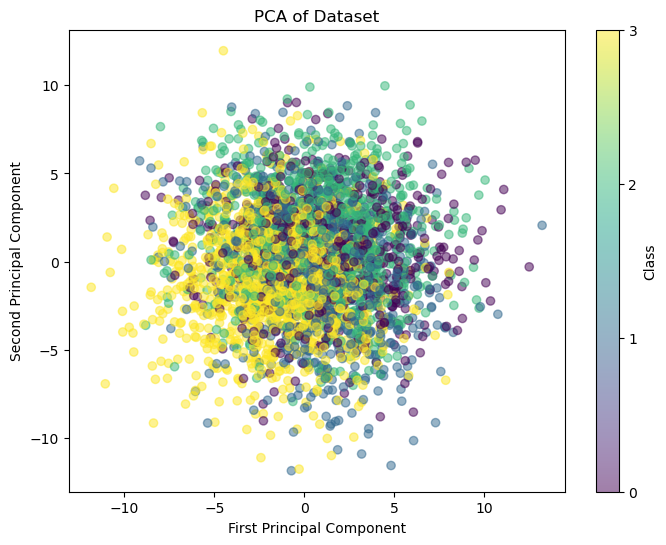

Variance explained by the first component: 0.59%
Variance explained by the second component: 0.56%
Feature contributing the most to the first PC: Gene 1569
Feature contributing the most to the second PC: Gene 408


In [35]:
# Plotting the first 2 PCs, colored by class labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=df["Outcome"], cmap='viridis', alpha=0.5)
plt.title('PCA of Dataset')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Class', ticks=(0,1,2,3))
plt.show()

# Variance explained by the first and second components
print(f"Variance explained by the first component: {pca.explained_variance_ratio_[0] * 100:.2f}%")
print(f"Variance explained by the second component: {pca.explained_variance_ratio_[1] * 100:.2f}%")

# Determining which feature contributes the most to each PC
pcs = pca.components_

# Identifing the index of the maximum absolute value in each PC
feature_contrib_first_pc = np.argmax(np.abs(pcs[0]))
feature_contrib_second_pc = np.argmax(np.abs(pcs[1]))

print(f"Feature contributing the most to the first PC: {X.columns[feature_contrib_first_pc]}")
print(f"Feature contributing the most to the second PC: {X.columns[feature_contrib_second_pc]}")

In [36]:
# We interpreted the questions as follows: split the original training data into training and validation sets without downsampling. In the previous questions we did work with the downsampled datasets
X_fulldf = df.drop('Outcome', axis=1)
y_fulldf = df['Outcome']

X_train_fulldf, X_val_fulldf, y_train_fulldf, y_val_fulldf = train_test_split(X_fulldf, y_fulldf, test_size=0.2, random_state=42)

In [37]:
# Defining the pipeline
pipeline_PCA_L2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),                                           # Imputing missing values with mean
    ('scaler', StandardScaler()),                                                          # Scaling the data
    ('pca', PCA(n_components=100)),                                                        # PCA step with 100 components,
    ('classifier', LogisticRegression(C=1, penalty='l2', solver='lbfgs', max_iter=10000))  # L2-regularized logistic regression
])

# Defining the scoring metrics for cross-validation
scoring = ['roc_auc_ovr', 'f1_macro']

# Performing 10-fold cross-validation
cv_results = cross_validate(pipeline_PCA_L2, X_train_fulldf, y_train_fulldf, cv=10, scoring=scoring)

# Calculating the average scores across all folds
avg_roc_auc_ovr_2 = cv_results['test_roc_auc_ovr'].mean()
avg_f1_macro_2 = cv_results['test_f1_macro'].mean()

print(f'Average ROC AUC Ov2: {avg_roc_auc_ovr_2}')
print(f'Average ROC AUC OvR improved {avg_roc_auc_ovr_2 - avg_roc_auc_ovr: .2%}\n')
print(f'Average F1 Macro: {avg_f1_macro_2}')
print(f'Average F1 Macro improved {avg_f1_macro_2 - avg_f1_macro: .2%}')

Average ROC AUC Ov2: 0.8808733708457671
Average ROC AUC OvR improved  1.34%

Average F1 Macro: 0.6568547224228557
Average F1 Macro improved  0.87%


In [38]:
# Datasets: Ensuring X_fulldf is aligned with y_fulldf first
y_fulldf = df['Outcome'].dropna()                                                                                                             # Drop NaN values from labels
X_fulldf = df.loc[y_fulldf.index, df.columns != 'Outcome']                                                                                    # Make sure to select the same rows in X


# Now, y_fulldf only contains non-NaN values and X_fulldf is aligned with y_fulldf
X_train_fulldf, X_val_fulldf, y_train_fulldf, y_val_fulldf = train_test_split(X_fulldf, y_fulldf, test_size=0.2, random_state=42)

# Defining the pipeline
pipelineX = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),                                                                                              # Add this line to impute missing values
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logistic', LogisticRegression(solver='lbfgs', max_iter=10000))
])


# Parameters space to explore
param_distributions = {
    'pca__n_components': [50, 100, 200, 500],
    'logistic__C': [0.01, 0.1, 1, 10, 100]
}

In [39]:
# Inner CV
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipelineX,
    param_distributions=param_distributions,
    n_iter=10,                                                                              # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='roc_auc_ovr',
    cv=inner_cv,
    random_state=42
)

# Outer CV
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Scores to collect
f1_macro_scores = []
roc_auc_scores = []

# Performing outer CV
for train_idx, test_idx in outer_cv.split(X_fulldf, y_fulldf):
    X_train_fulldf, X_val_fulldf = X_fulldf.iloc[train_idx], X_fulldf.iloc[test_idx]
    y_train_fulldf, y_val_fulldf = y_fulldf.iloc[train_idx], y_fulldf.iloc[test_idx]

    random_search.fit(X_train_fulldf, y_train_fulldf)

    best_model = random_search.best_estimator_                                                # Shows best hyperparameters to use for the model
    y_pred = best_model.predict(X_val_fulldf)
    y_pred_proba = best_model.predict_proba(X_val_fulldf)

    # Calculating scores
    f1_macro = f1_score(y_val_fulldf, y_pred, average='macro')
    roc_auc = roc_auc_score(y_val_fulldf, y_pred_proba, multi_class='ovr', average='macro')

    f1_macro_scores.append(f1_macro)
    roc_auc_scores.append(roc_auc)

# Reporting average scores
print(f'Average F1 Macro: {np.mean(f1_macro_scores)}')
print(f'Average ROC AUC OvR: {np.mean(roc_auc_scores)}')

Average F1 Macro: 0.686838411748171
Average ROC AUC OvR: 0.8981516262835779


In [40]:
# Defining the pipeline
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier(n_estimators=250, n_jobs=-2, random_state=42))
])

# Cross-validation scores
auc_roc_scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
f1_macro_scorer = make_scorer(f1_score, average='macro')

auc_roc_scores = cross_val_score(pipeline_rf, X_fulldf, y_fulldf, cv=5, scoring=auc_roc_scorer)
f1_macro_scores = cross_val_score(pipeline_rf, X_fulldf, y_fulldf, cv=5, scoring=f1_macro_scorer)

print(f"Average AUC ROC OVR: {np.mean(auc_roc_scores)}")
print(f"Average F1 Macro: {np.mean(f1_macro_scores)}")

Average AUC ROC OVR: 0.86333719756735
Average F1 Macro: 0.3885530439638182


Top 5 Features:
Feature 279 - Importance: 0.00210734136816776
Feature 1522 - Importance: 0.0025521286389544907
Feature 53 - Importance: 0.0025740038063593257
Feature 1881 - Importance: 0.002736271281483081
Feature 1797 - Importance: 0.0033272164056493986


C:\Users\veldh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


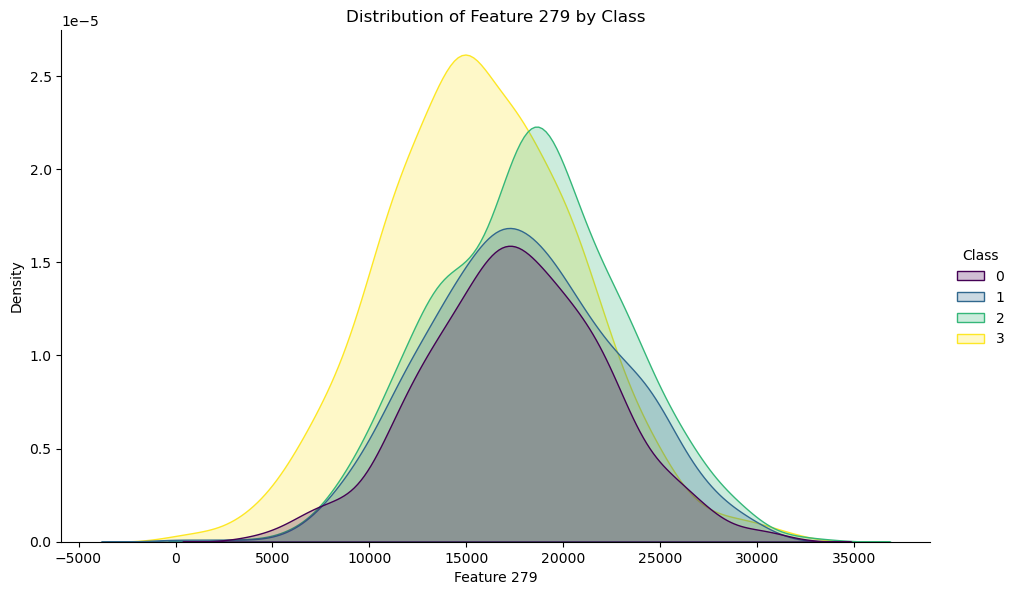

C:\Users\veldh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


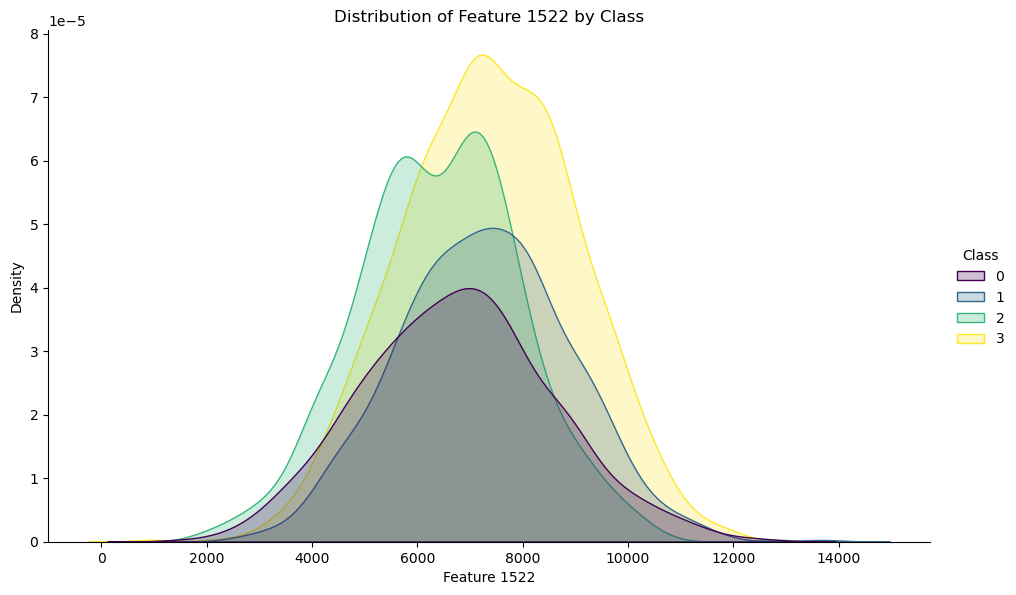

C:\Users\veldh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


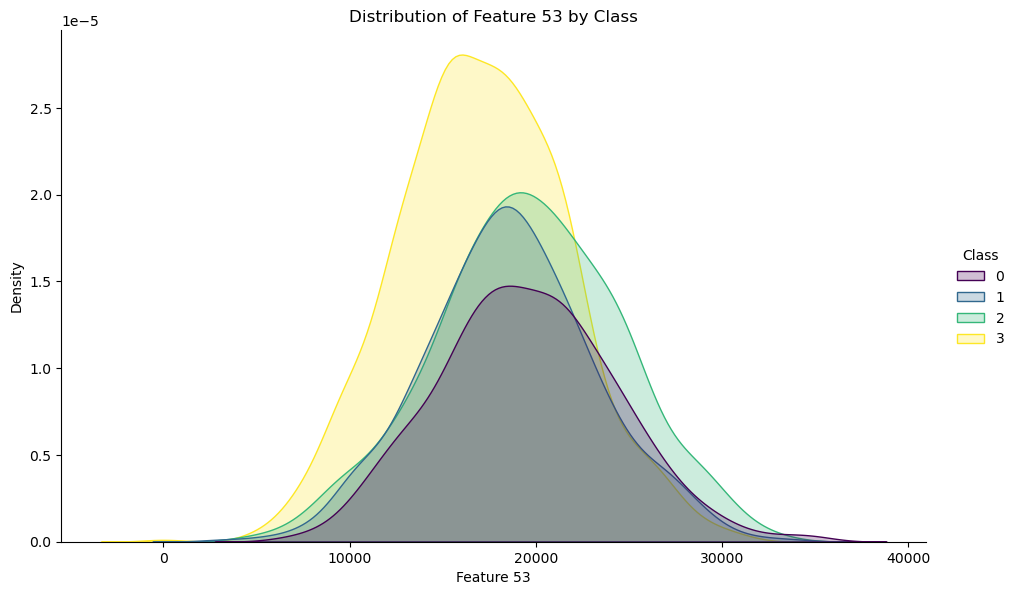

C:\Users\veldh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


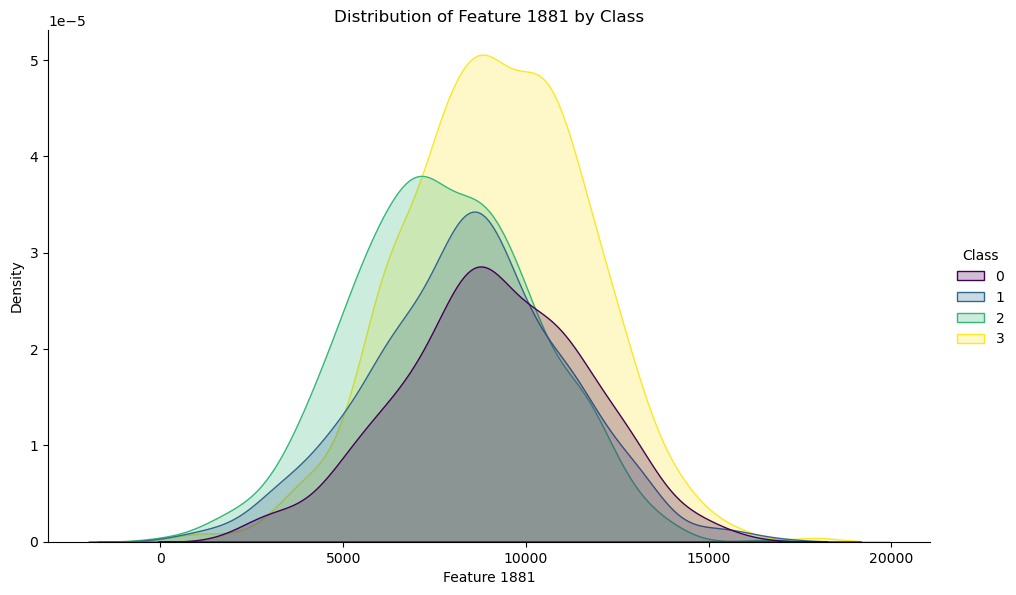

C:\Users\veldh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


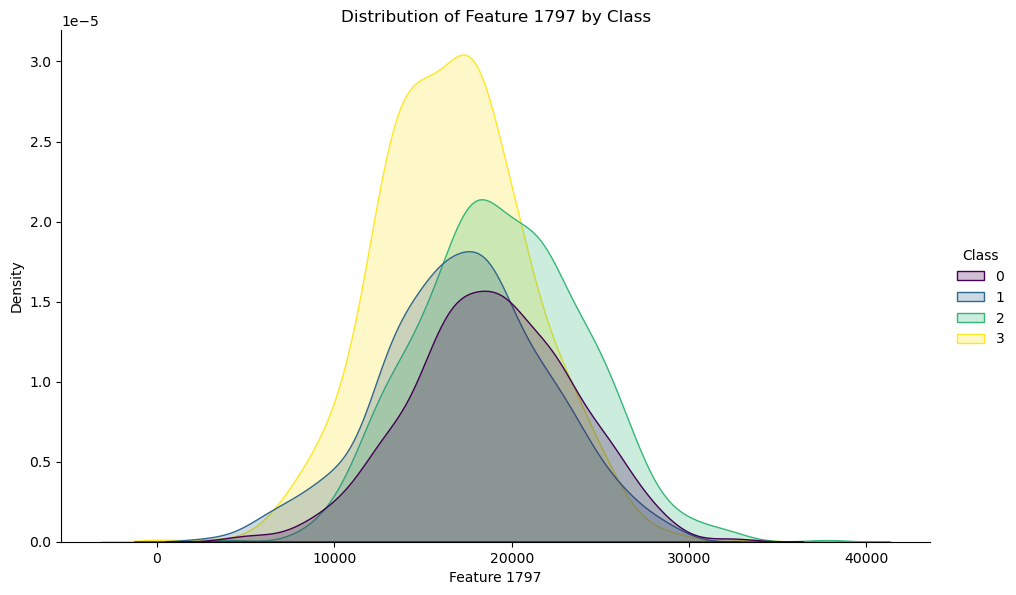

In [41]:
# Training the model on all training data
pipeline_rf.fit(X_fulldf, y_fulldf)

# Getting feature importances
feature_importances = pipeline_rf.named_steps['rf'].feature_importances_

# Identifying the top 5 features
top_features_indices = np.argsort(feature_importances)[-5:]
top_features_importances = feature_importances[top_features_indices]

print("Top 5 Features:")
for i, index in enumerate(top_features_indices):
    print(f"Feature {index} - Importance: {top_features_importances[i]}")

# Plotting
for feature_idx in top_features_indices:
    plot_data = pd.DataFrame({                                                                    # Create a new DataFrame for plotting that includes the feature and the class labels
        'Feature Value': df.iloc[:, feature_idx],
        'Class': y_fulldf
    })
    sns.displot(data=plot_data, x='Feature Value', hue='Class', kind='kde', fill=True, palette='viridis', height=6, aspect=1.6)
    plt.title(f"Distribution of Feature {feature_idx} by Class")
    plt.xlabel(f"Feature {feature_idx}")
    plt.ylabel("Density")
    plt.show()

In [42]:
# Setting nans to -1
X_train_fulldf = X_train_fulldf.copy()
X_val_fulldf = X_val_fulldf.copy()
y_train_fulldf = y_train_fulldf.copy()
y_val_fulldf = y_val_fulldf.copy()

X_train_fulldf.fillna(-1, inplace=True)
X_val_fulldf.fillna(-1, inplace=True)
y_train_fulldf.fillna(-1, inplace=True)
y_val_fulldf.fillna(-1, inplace=True)

y_train_fulldf_np = y_train_fulldf.to_numpy()

scaler = StandardScaler()
X_train_scaled_fulldf = scaler.fit_transform(X_train_fulldf)

def build_model(input_shape):
    model = Sequential([
        Dense(30, activation="relu", input_shape=input_shape),
        Dense(20, activation="relu"),
        Dense(10, activation="relu"),
        Dense(4, activation="softmax")
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

n_splits = 5
cv_scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_train_scaled_fulldf, y_train_fulldf_np):
    X_train, X_test = X_train_scaled_fulldf[train_index], X_train_scaled_fulldf[test_index]
    y_train, y_test = y_train_fulldf_np[train_index], y_train_fulldf_np[test_index]

    model = build_model((X_train.shape[1],))
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)

    score = accuracy_score(y_test, predictions)
    cv_scores.append(score)

print(f"CV scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores)}")





18/18 [==============================] - 0s 2ms/step
CV scores: [0.6294326241134752, 0.6234458259325044, 0.6039076376554174, 0.6394316163410302, 0.6234458259325044]
Mean CV accuracy: 0.6239327059949863


In [43]:
# Used datasets
X_fulldf, y_fulldf

# Defining the pipeline
pipeline_XGB = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

param_distributions = {
    'smote__k_neighbors': [3, 5, 7],
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5, 7]
}

In [44]:
# Use ROC AUC score for multi-class as the scoring parameter
roc_auc_ovr_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
f1_macro_scorer = make_scorer(f1_score, average='macro')

random_search = RandomizedSearchCV(
    pipeline_XGB,
    param_distributions=param_distributions,
    n_iter=10,
    scoring={'roc_auc_ovr': roc_auc_ovr_scorer, 'f1_macro': f1_macro_scorer},
    refit='roc_auc_ovr',                                                                              # Choose which scorer to use to pick the best model
    cv=StratifiedKFold(2),                                                                            # Set to 2 (to reduce runtime)
    verbose=3,
    random_state=42
)

random_search.fit(X_fulldf, y_fulldf)

print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC OvR score:", random_search.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END classifier__learning_rate=0.1, classifier__max_depth=7, classifier__n_estimators=200, smote__k_neighbors=7; f1_macro: (test=0.676) roc_auc_ovr: (test=0.901) total time= 4.0min
[CV 2/2] END classifier__learning_rate=0.1, classifier__max_depth=7, classifier__n_estimators=200, smote__k_neighbors=7; f1_macro: (test=0.684) roc_auc_ovr: (test=0.902) total time= 4.0min
[CV 1/2] END classifier__learning_rate=0.01, classifier__max_depth=7, classifier__n_estimators=100, smote__k_neighbors=5; f1_macro: (test=0.500) roc_auc_ovr: (test=0.773) total time= 3.8min
[CV 2/2] END classifier__learning_rate=0.01, classifier__max_depth=7, classifier__n_estimators=100, smote__k_neighbors=5; f1_macro: (test=0.510) roc_auc_ovr: (test=0.765) total time= 3.7min
[CV 1/2] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100, smote__k_neighbors=7; f1_macro: (test=0.682) roc_auc_ovr: (test=0.897) total time=

In [45]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_fulldf)
y_proba = best_model.predict_proba(X_fulldf)

print("Test Set Evaluation:")
print("ROC AUC OvR: ", roc_auc_score(y_fulldf, y_proba, multi_class='ovr'))
print("F1 Macro: ", f1_score(y_fulldf, y_pred, average='macro'))

Test Set Evaluation:
ROC AUC OvR:  0.9999454261397815
F1 Macro:  0.9947482018508514


In [46]:
# New dataframes for using the ML models on the test data
df_train = pd.read_csv("train_2024.csv")
df_test = pd.read_csv("test_2024.csv")
df_outcome = pd.read_csv("answer_key_2024.csv")
df_merged = pd.merge(df_test, df_outcome, on='Id', how='left')


# Datasets: Ensuring X_dataset is aligned with y_dataset first
y_complete_train1 = df_train['Outcome']
y_complete_train = y_complete_train1.dropna()                                                   # Drop NaN values from labels

X_complete_train1 = df_train.drop('Outcome', axis=1)
X_complete_train = df_train.loc[y_complete_train.index, df_train.columns != 'Outcome']          # Make sure to select the same rows in X


y_complete_val1 = df_merged['Outcome']
y_complete_val = y_complete_val1.dropna()                                                       # Drop NaN values from labels

X_complete_val1 = df_merged.drop('Outcome', axis=1)
X_complete_val = df_merged.loc[y_complete_val.index, df_merged.columns != 'Outcome']            # Make sure to select the same rows in X

In [47]:
# Function for evaluation
def evaluate_model(pipeline, X_complete_train, y_complete_train, X_complete_val, y_complete_val):
    # Fit
    pipeline.fit(X_complete_train, y_complete_train)

    # Predict on the validation set
    y_val_pred = pipeline.predict(X_complete_val)
    y_val_prob = pipeline.predict_proba(X_complete_val)

    # Evaluate the performance on the validation set
    roc_auc_val = roc_auc_score(y_complete_val, y_val_prob, multi_class='ovr', average='macro')
    f1_score_val = f1_score(y_complete_val, y_val_pred, average='macro')

    print(f'Validation ROC AUC (One-vs-Rest): {roc_auc_val}')
    print(f'Validation Macro F1 Score: {f1_score_val}')

In [48]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),                                        # Imputing missing values with mean
    ('scaler', StandardScaler()),                                                       # Scaling the data
    ('logistic_regression', LogisticRegression(C=1e5, solver='lbfgs', max_iter=10000))  # Logistic regression
])

evaluate_model(
pipeline=pipeline,
X_complete_train=X_complete_train,
y_complete_train=y_complete_train,
X_complete_val=X_complete_val,
y_complete_val=y_complete_val
)

Validation ROC AUC (One-vs-Rest): 0.8408275462962963
Validation Macro F1 Score: 0.6150555511171706


In [49]:
pipeline_L2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),                                           # Imputing missing values with mean
    ('scaler', StandardScaler()),                                                          # Scaling the data
    ('classifier', LogisticRegression(C=1, penalty='l2', solver='lbfgs', max_iter=10000))  # L2-regularized logistic regression
])

evaluate_model(
pipeline=pipeline_L2,
X_complete_train=X_complete_train,
y_complete_train=y_complete_train,
X_complete_val=X_complete_val,
y_complete_val=y_complete_val
)

Validation ROC AUC (One-vs-Rest): 0.8522858796296297
Validation Macro F1 Score: 0.6176832479589388


In [50]:
pipeline_PCA_L2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),                                           # Imputing missing values with mean
    ('scaler', StandardScaler()),                                                          # Scaling the data
    ('pca', PCA(n_components=100)),                                                        # PCA step with 100 components,
    ('classifier', LogisticRegression(C=1, penalty='l2', solver='lbfgs', max_iter=10000))  # L2-regularized logistic regression
])

evaluate_model(
pipeline=pipeline_PCA_L2,
X_complete_train=X_complete_train,
y_complete_train=y_complete_train,
X_complete_val=X_complete_val,
y_complete_val=y_complete_val
)

Validation ROC AUC (One-vs-Rest): 0.8979918981481482
Validation Macro F1 Score: 0.6700392224620605


In [51]:
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier(n_estimators=250, n_jobs=-2, random_state=42))
])

evaluate_model(
pipeline=pipeline_rf,
X_complete_train=X_complete_train,
y_complete_train=y_complete_train,
X_complete_val=X_complete_val,
y_complete_val=y_complete_val
)

Validation ROC AUC (One-vs-Rest): 0.8672193287037037
Validation Macro F1 Score: 0.4087516794530911


In [52]:
pipeline_XGB = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

best_params = {
    'smote__k_neighbors': 3,
    'classifier__n_estimators': 200,
    'classifier__max_depth': 3,
    'classifier__learning_rate': 0.1
}

pipeline_XGB.set_params(**best_params)

evaluate_model(
pipeline=pipeline_XGB,
X_complete_train=X_complete_train,
y_complete_train=y_complete_train,
X_complete_val=X_complete_val,
y_complete_val=y_complete_val
)

Validation ROC AUC (One-vs-Rest): 0.9351331018518518
Validation Macro F1 Score: 0.7601676059274939
